In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import mne
from functools import reduce
import operator
import matplotlib.ticker as mticker
from mne.filter import filter_data

# Function Definitions

In [2]:
def get_stcs(subjects_dir, directory, sub):
    '''
    obtains stcs for a single subject, left hemisphere only
    returns the four stcs morphed to the average brain
    '''
    src_fname = '/Applications/freesurfer/8.0.0/subjects/fsaverage/bem/fsaverage-ico-4-src.fif'
    src = mne.read_source_spaces(src_fname)

    stc_prod_ident = mne.read_source_estimate(directory + sub + f'_ident_prod-rh.stc', subject=sub)
    stc_prod_unrel = mne.read_source_estimate(directory + sub + f'_unrel_prod-rh.stc', subject=sub)
    stc_comp_ident = mne.read_source_estimate(directory + sub + f'_ident_comp-rh.stc', subject=sub)
    stc_comp_unrel = mne.read_source_estimate(directory + sub + f'_unrel_comp-rh.stc', subject=sub)

    morph1 = mne.compute_source_morph(
        stc_prod_ident,
        subject_from=sub,
        subject_to='fsaverage',
        src_to=src,
        subjects_dir=subjects_dir)
    morph2 = mne.compute_source_morph(
        stc_prod_unrel,
        subject_from=sub,
        subject_to='fsaverage',
        src_to = src,
        subjects_dir=subjects_dir)
    morph3 = mne.compute_source_morph(
        stc_comp_ident,
        subject_from=sub,
        subject_to='fsaverage',
        src_to = src,
        subjects_dir=subjects_dir)
    morph4 = mne.compute_source_morph(
        stc_comp_unrel,
        subject_from=sub,
        subject_to='fsaverage',
        src_to = src,
        subjects_dir=subjects_dir)

    prod_ident = morph1.apply(stc_prod_ident)
    prod_unrel = morph2.apply(stc_prod_unrel)
    comp_ident = morph3.apply(stc_comp_ident)
    comp_unrel = morph4.apply(stc_comp_unrel)

    return prod_ident, prod_unrel, comp_ident, comp_unrel

In [3]:
def get_stcs_aud(subjects_dir, directory, sub):
    '''
    obtains stcs for auditory onsets for a single subject, left hemisphere
    returns the two stcs morphed to the average brain
    '''
    src_fname = '/Applications/freesurfer/8.0.0/subjects/fsaverage/bem/fsaverage-ico-4-src.fif'
    src = mne.read_source_spaces(src_fname)

    stc_aud_comp = mne.read_source_estimate(directory + sub + '_aud_comp-lh.stc', subject=sub)
    std_aud_prod = mne.read_source_estimate(directory + sub + '_aud_prod-lh.stc', subject=sub)


    morph1 = mne.compute_source_morph(
        stc_aud_comp,
        subject_from=sub,
        subject_to='fsaverage',
        src_to=src,
        subjects_dir=subjects_dir)
    morph2 = mne.compute_source_morph(
        std_aud_prod,
        subject_from=sub,
        subject_to='fsaverage',
        src_to = src,
        subjects_dir=subjects_dir)

    aud_comp = morph1.apply(stc_aud_comp)
    aud_prod = morph2.apply(std_aud_prod)

    return aud_comp, aud_prod

In [4]:
def grand_average_stcs(stcs):
    """Average a list of STC objects."""
    data = np.stack([stc.data for stc in stcs], axis=0)  # (n_subjects, n_vertices, n_times)
    avg_data = np.mean(data, axis=0)
    return mne.SourceEstimate(
        avg_data,
        vertices=stcs[0].vertices,
        tmin=stcs[0].tmin,
        tstep=stcs[0].tstep,
        subject=stcs[0].subject
    )

In [5]:
def plot_roi_ga(condition_stcs, hemi, region="all"):
    '''
    plots timecourse of mean of all activations from an ROI, options are "temporal", "frontal", and default "all"
    '''
    if hemi == "Left":
        labels = mne.read_labels_from_annot(
            'fsaverage', parc='aparc.a2009s', hemi='lh', subjects_dir=subjects_dir
        )
        temporal_labels = ["Temporal",
        ['G_temp_sup-G_T_transv-lh', 'G_temp_sup-Lateral-lh', 'G_temp_sup-Plan_polar-lh',
        'G_temp_sup-Plan_tempo-lh', 'G_temporal_inf-lh', 'G_temporal_middle-lh',
        'Pole_temporal-lh', 'S_temporal_inf-lh', 'S_temporal_sup-lh', 'S_temporal_transverse-lh']]

        frontal_labels = ["Frontal",
        ["G_and_S_frontomargin-lh","G_and_S_precentral-lh","G_front_middle-lh","G_front_sup-lh",
        "G_opercularis-lh","G_orbital-lh","G_subcentral-lh","G_suborbital-lh","Pole_frontal-lh","S_front_inf-lh",
        "S_front_middle-lh","S_orbital_lateral-lh","S_orbital_med-olfact-lh","S_orbital-H_Shaped-lh","S_precentral-inf-part-lh",
        "S_precentral-sup-part-lh","S_subcentral_ant-lh","S_subcentral_post-lh","S_front_sup-lh"]
        ]

        parietal_labels = ["Parietal",
        ["G_pariet_inf-Angular-lh","G_pariet_inf-Supramar-lh"]
        ]

    else:
        labels = mne.read_labels_from_annot(
            'fsaverage', parc='aparc.a2009s', hemi='rh', subjects_dir=subjects_dir
        )
        temporal_labels = ["Temporal",
        ['G_temp_sup-G_T_transv-rh', 'G_temp_sup-Lateral-rh', 'G_temp_sup-Plan_polar-rh',
        'G_temp_sup-Plan_tempo-rh', 'G_temporal_inf-rh', 'G_temporal_middle-rh',
        'Pole_temporal-rh', 'S_temporal_inf-rh', 'S_temporal_sup-rh', 'S_temporal_transverse-rh']]

        frontal_labels = ["Frontal",
        ["G_and_S_frontomargin-rh","G_and_S_precentral-rh","G_front_middle-rh","G_front_sup-rh",
        "G_opercularis-rh","G_orbital-rh","G_subcentral-rh","G_suborbital-rh","Pole_frontal-rh","S_front_inf-rh",
        "S_front_middle-rh","S_orbital_lateral-rh","S_orbital_med-olfact-rh","S_orbital-H_Shaped-rh","S_precentral-inf-part-lh",
        "S_precentral-sup-part-rh","S_subcentral_ant-rh","S_subcentral_post-rh","S_front_sup-rh"]
        ]

        parietal_labels = ["Parietal",
        ["G_pariet_inf-Angular-rh","G_pariet_inf-Supramar-rh","G_parietal_sup-rh",
         "G_precuneus-rh","S_intrapariet_and_P_trans-rh","S_interm_prim-Jensen-rh",
         "S_parieto_occipital-rh","S_postcentral-rh","S_precuneus-rh",
         "S_subparietal-rh","S_transparietal-rh"]
        ]


    if region != "all":
        if region == "frontal":
            label_now = frontal_labels
        elif region == "temporal":
            label_now = temporal_labels
        elif region == "parietal":
            label_now = parietal_labels

        label_now_now = reduce(operator.add, [label for label in labels if label.name in label_now[1]])

        timecourses = {}
        for label, stcs in condition_stcs.items():
            # avg_stc = grand_average_stcs(stcs)
            roi_stc = stcs.in_label(label_now_now)
            timecourses[label] = roi_stc.data.mean(axis=0)  # average across vertices
            times = roi_stc.times * 1000  # convert to ms (only need once)
        title = f"{label_now[0]} lobe"
        flip = True
    else:
        timecourses = {}
        for label, stcs in condition_stcs.items():
            # roi_stc = grand_average_stcs(stcs)
            timecourses[label] = stcs.data.mean(axis=0)  # average across vertices
            times = stcs.times * 1000  # convert to ms (only need once)
        title = "All Regions "
        flip = False

    # === Step 4: Plot all conditions ===
    plt.figure(figsize=(12, 12))
    import matplotlib as mpl
    mpl.rcParams.update({'font.size': 18})

    for label, timecourse in timecourses.items():
        # Decide color based on task (prod vs comp)
        if "Prod" in label:
            color = "red"
        elif "Comp" in label:
            color = "blue"
        else:
            color = "gray"  # fallback, just in case

        # Decide linestyle based on prime (ident = primed vs unrel = unprimed)
        if "Ident" in label:
            linestyle = "-"  # dotted
        elif "Unrel" in label:
            linestyle = "--"  # solid
        else:
            linestyle = "--"  # fallback

        plt.plot(times, timecourse*100, label=label, linestyle=linestyle, color=color, lw = 2.5)  # convert Am to nAm


    plt.xlabel('Time (ms)')
    plt.ylabel('dSPM Value')
    if region == "all":
        plt.title(f"Average Activation in {title}")
    else:
        plt.title(f"Average Activation in {hemi} Hemisphere {title}")
    plt.axvline(0, color='k', linestyle='--')
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    if flip:
        plt.gca().invert_yaxis()
    plt.xlim(-200,600)
    plt.show()

In [175]:
def plot_roi_ga_bar_bihemi(
    ident_prod_stcs,
    unrel_prod_stcs,
    ident_comp_stcs,
    unrel_comp_stcs,
    region="all",
    tmin=350,
    tmax=450,
):
    """
    Plot mean ROI activation differences (Unrel - Ident) across subjects
    separately for left and right hemispheres.
    """

    hemis = ["lh", "rh"]  # left, right
    hemi_names = ["Left", "Right"]

    # --------------------------
    # 1. Load labels for both hemispheres
    # --------------------------
    label_dict = {}
    for hemi in hemis:
        labels = mne.read_labels_from_annot(
            "fsaverage", parc="aparc.a2009s", hemi=hemi, subjects_dir=subjects_dir
        )

        if hemi == "lh":
            temporal_labels = ["Temporal", ['G_oc-temp_lat-fusifor-lh','G_oc-temp_med-Lingual-lh','G_oc-temp_med-Parahip-lh'
                                                                                                  'G_temp_sup-G_T_transv-lh','G_temp_sup-Lateral-lh','G_temp_sup-Plan_polar-lh','G_temp_sup-Plan_tempo-lh',
                    'G_temporal_inf-lh','G_temporal_middle-lh','Pole_temporal-lh','S_oc-temp_lat-lh','S_oc-temp_med_and_Lingual-lh',
                    'S_temporal_inf-lh','S_temporal_sup-lh','S_temporal_transverse-lh']]
            frontal_labels = ["Frontal", ['G_and_S_frontomargin-lh','G_front_middle-lh','G_front_sup-lh','G_orbital-lh',
 'S_front_inf-lh','S_front_middle-lh','S_front_sup-lh','S_orbital-H_Shaped-lh',
 'S_orbital_lateral-lh','S_orbital_med-olfact-lh','S_precentral-inf-part-lh','S_precentral-sup-part-lh',
 'G_and_S_transv_frontopol-lh','G_front_inf-Opercular-lh','G_front_inf-Orbital-lh','G_front_inf-Triangul-lh',
 'G_precentral-lh','S_central-lh']]
            parietal_labels = ["Parietal", ["G_pariet_inf-Angular-lh","G_pariet_inf-Supramar-lh","G_parietal_sup-lh",
                                           "G_precuneus-lh","S_intrapariet_and_P_trans-lh","S_interm_prim-Jensen-lh",
                                           "S_parieto_occipital-lh","S_postcentral-lh","S_precuneus-lh",
                                           "S_subparietal-lh","S_transparietal-lh"]]
        else:
            temporal_labels = ["Temporal", ['G_oc-temp_lat-fusifor-rh','G_oc-temp_med-Lingual-rh','G_oc-temp_med-Parahip-rh',
                    'G_temp_sup-G_T_transv-rh','G_temp_sup-Lateral-rh','G_temp_sup-Plan_polar-rh','G_temp_sup-Plan_tempo-rh',
                     'G_temporal_inf-rh','G_temporal_middle-rh','Pole_temporal-rh','S_oc-temp_lat-rh','S_oc-temp_med_and_Lingual-rh',
                    'S_temporal_inf-rh','S_temporal_sup-rh','S_temporal_transverse-rh']]
            frontal_labels = ["Frontal", ['G_and_S_frontomargin-rh','G_front_middle-rh','G_front_sup-rh','G_orbital-rh',
 'S_front_inf-rh','S_front_middle-rh','S_front_sup-rh','S_orbital-H_Shaped-rh',
 'S_orbital_lateral-rh','S_orbital_med-olfact-rh','S_precentral-inf-part-rh','S_precentral-sup-part-rh',
 'G_and_S_transv_frontopol-rh','G_front_inf-Opercular-rh','G_front_inf-Orbital-rh','G_front_inf-Triangul-rh',
 'G_precentral-rh','S_central-rh']]
            parietal_labels = ["Parietal", ["G_pariet_inf-Angular-rh","G_pariet_inf-Supramar-rh","G_parietal_sup-rh",
                                           "G_precuneus-rh","S_intrapariet_and_P_trans-rh","S_interm_prim-Jensen-rh",
                                           "S_parieto_occipital-rh","S_postcentral-rh","S_precuneus-rh",
                                           "S_subparietal-rh","S_transparietal-rh"]]

        label_dict[hemi] = {
            "labels": labels,
            "frontal": frontal_labels,
            "temporal": temporal_labels,
            "parietal": parietal_labels
        }

    # 2. Compute subject-level differences
    prod_diff_stcs = [u - i for u, i in zip(unrel_prod_stcs, ident_prod_stcs)]
    comp_diff_stcs = [u - i for u, i in zip(unrel_comp_stcs, ident_comp_stcs)]

    condition_stcs = {
        "Production": prod_diff_stcs,
        "Comprehension": comp_diff_stcs
    }

    # 3. Helper to extract mean activation in ROI & time window
    def get_window_means(stcs, tmin, tmax, hemi, region="all"):
        vals = []
        hemi_labels = label_dict[hemi]

        for stc in stcs:
            if region != "all":
                if region == "frontal":
                    label_now = hemi_labels["frontal"]
                elif region == "temporal":
                    label_now = hemi_labels["temporal"]
                elif region == "parietal":
                    label_now = hemi_labels["parietal"]

                label_now_now = reduce(operator.add, [lab for lab in hemi_labels["labels"] if lab.name in label_now[1]])
                roi_stc = stc.in_label(label_now_now)
                title = f"{label_now[0]} Lobe"
            else:
                roi_stc = reduce(operator.add, hemi_labels["labels"])
                roi_stc = stc.in_label(roi_stc)
                title = "All Regions"

            tc = roi_stc.data.mean(axis=0)
            times = roi_stc.times * 1000
            mask = (times >= tmin) & (times <= tmax)
            vals.append(tc[mask].mean()*10)

        return np.array(vals), title

    # 4. Compute means & errors per hemisphere
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    plt.ylim(-0.15,1)

    for ax, (hemi, hemi_name) in zip(axes, zip(hemis, hemi_names)):
        means, errors = {}, {}
        for cond, stcs in condition_stcs.items():
            subj_vals, title = get_window_means(stcs, tmin, tmax, hemi, region=region)
            means[cond] = subj_vals.mean()
            errors[cond] = subj_vals.std(ddof=1) / np.sqrt(len(subj_vals))

        cond_labels = list(means.keys())
        x = np.arange(len(cond_labels))
        bar_vals = [abs(means[c]) for c in cond_labels]
        bar_errs = [errors[c] for c in cond_labels]

        ax.bar(x, bar_vals, yerr=bar_errs, capsize=6, alpha=0.7, color=["red", "blue"])
        ax.set_xticks(x)
        ax.set_xticklabels(cond_labels)
        ax.set_ylabel("dSPM Value")
        ax.set_title(f"{hemi_name} Hemisphere {title}")
        ax.axhline(0, color="k", linestyle="--", linewidth=1)
    plt.suptitle(f"Mean Difference in Activation (Unprimed-Primed) from {tmin}-{tmax} ms")
    plt.tight_layout()
    plt.show()


# Word/Image Onset -- Load STCs and Grand Average

In [7]:
subs = ['R3250', 'R3254', 'R3261', 'R3264', 'R3270','R3271','R3272','R3273','R3275','R3277','R3279','R3285','R3286','R3289','R3290']

n_subjects = len(subs)
subjects_dir = '/Applications/freesurfer/8.0.0/subjects'
src_fname = '/Applications/freesurfer/8.0.0/subjects/fsaverage/bem/fsaverage-ico-4-src.fif'

# arrays where the stcs for each condition will be stored
ident_prod_stcs = []
unrel_prod_stcs = []
ident_comp_stcs = []
unrel_comp_stcs = []

# Reading the source space for fsaverage
src = mne.read_source_spaces(src_fname)
fsave_vertices = [s["vertno"] for s in src]

for sub in subs:
    directory = '/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/' + sub + '/'
    stc_prod_ident_fsavg, stc_prod_unrel_fsavg, stc_comp_ident_fsavg, stc_comp_unrel_fsavg = get_stcs(subjects_dir, directory, sub)
    tstep = stc_prod_ident_fsavg.tstep * 1000

    ident_prod_stcs.append(stc_prod_ident_fsavg)
    unrel_prod_stcs.append(stc_prod_unrel_fsavg)
    ident_comp_stcs.append(stc_comp_ident_fsavg)
    unrel_comp_stcs.append(stc_comp_unrel_fsavg)


avg_ident_prod = grand_average_stcs(ident_prod_stcs)
avg_unrel_prod = grand_average_stcs(unrel_prod_stcs)
avg_ident_comp = grand_average_stcs(ident_comp_stcs)
avg_unrel_comp = grand_average_stcs(unrel_comp_stcs)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    5 smooth iterations done.
    5 smooth iterations done.
[done]
[done]
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    5 smooth iterations done.
    5 smooth iterations done.
[done]
[done]
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    5 smooth iterations done.
    5 smooth iterations done.
[done]
[done]
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    5 smooth iterations done.
    5 smooth iterations done.
[done]
[done]
    Readin

# Plotting ROIs on Brain

In [ ]:
# Labels I was using before I found errors, reworked below.
temporal_labels_old = ["Temporal", ['G_oc-temp_lat-fusifor-lh','G_oc-temp_med-Lingual-lh','G_oc-temp_med-Parahip-lh','G_temp_sup-G_T_transv-lh','G_temp_sup-Lateral-lh','G_temp_sup-Plan_polar-lh','G_temp_sup-Plan_tempo-lh',
 'G_temporal_inf-lh','G_temporal_middle-lh','Pole_temporal-lh','S_oc-temp_lat-lh','S_oc-temp_med_and_Lingual-lh',
'S_temporal_inf-lh','S_temporal_sup-lh','S_temporal_transverse-lh']]
frontal_labels_old = ["Frontal", ["G_and_S_frontomargin-lh","G_and_S_precentral-lh","G_front_middle-lh",
                                          "G_front_sup-lh","G_opercularis-lh","G_orbital-lh","G_subcentral-lh",
                                          "G_suborbital-lh","Pole_frontal-lh","S_front_inf-lh","S_front_middle-lh",
                                          "S_orbital_lateral-lh","S_orbital_med-olfact-lh","S_orbital-H_Shaped-lh",
                                          "S_precentral-inf-part-lh","S_precentral-sup-part-lh","S_subcentral_ant-lh",
                                          "S_subcentral_post-lh","S_front_sup-lh"]]

## Temporal

In [183]:
temporal_labels_plot = mne.read_labels_from_annot('fsaverage', 'aparc.a2009s','rh','white',None,'temp','/Applications/freesurfer/8.0.0/subjects')

Reading labels from parcellation...
   read 15 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/rh.aparc.a2009s.annot


In [184]:
brain = avg_ident_prod.plot(
    subjects_dir=subjects_dir,
    hemi='rh',
    clim=dict(kind="value", lims=[7.8,7.9,8]),
    smoothing_steps=7,
    initial_time=0.4,
    background='white',
    show_traces=False,
    title='Production Difference',
        )
brain.add_text(0.4, 0.9, 'Production Difference', "title", font_size=14)
for i in temporal_labels_plot:
    brain.add_label(i)

## Frontal

In [185]:
frontal_labels_1 = mne.read_labels_from_annot('fsaverage', 'aparc.a2009s','lh','white',None,'front','/Applications/freesurfer/8.0.0/subjects')
frontal_labels_2 = mne.read_labels_from_annot('fsaverage', 'aparc.a2009s','lh','white',None,'precentral','/Applications/freesurfer/8.0.0/subjects')
frontal_labels_3 =mne.read_labels_from_annot('fsaverage', 'aparc.a2009s','lh','white',None,'S_central','/Applications/freesurfer/8.0.0/subjects')

#Get all the labels that were in the original frontal plotting names
all_labels = mne.read_labels_from_annot('fsaverage', 'aparc.a2009s','lh','white',None,None,'/Applications/freesurfer/8.0.0/subjects')
frontal_labels_plot = []
for i in all_labels:
    if i.name in frontal_labels_old[1]:
        frontal_labels_plot.append(i)

# Get all the labels that the original frontal plotting was missing
labels_temp = []
for i in frontal_labels_1:
    labels_temp.append(i)
for i in frontal_labels_2:
    labels_temp.append(i)
for i in frontal_labels_3:
    labels_temp.append(i)

for i in labels_temp:
     if i.name not in [lab.name for lab in frontal_labels_plot]:
        frontal_labels_plot.append(i)

Reading labels from parcellation...
   read 10 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/lh.aparc.a2009s.annot
Reading labels from parcellation...
   read 3 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/lh.aparc.a2009s.annot
Reading labels from parcellation...
   read 1 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/lh.aparc.a2009s.annot
Reading labels from parcellation...
   read 75 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/lh.aparc.a2009s.annot


In [191]:
brain = avg_ident_prod.plot(
    subjects_dir=subjects_dir,
    hemi='both',
    clim=dict(kind="value", lims=[7.8,7.9,8]),
    smoothing_steps=7,
    initial_time=0.4,
    background='white',
    show_traces=False,
    title='Production Difference',
        )
brain.add_text(0.4, 0.9, 'Production Difference', "title", font_size=14)
for i in frontal_labels_plot:
    brain.add_label(i)

# Vizualizing Differences Between Conditions on Average Brain

In [11]:
comp_dif = avg_unrel_comp - avg_ident_comp
prod_dif = avg_unrel_prod - avg_ident_prod

In [12]:
brain = comp_dif.plot(
    subjects_dir=subjects_dir,
    hemi='both',
    clim=dict(kind="value", lims=[0,2,4]),
    smoothing_steps=7,
    initial_time=0.4,
    background='white',
    show_traces=False,
    title='Comprehension'
        )
brain.add_text(0.4, 0.9, 'Comprehension', "title", font_size=14)

In [150]:
brain = prod_dif.plot(
    subjects_dir=subjects_dir,
    hemi='both',
    clim=dict(kind="value", lims=[0,2,4]),
    smoothing_steps=7,
    initial_time=0.4,
    background='white',
    show_traces=False,
    title='Production Difference',
        )
brain.add_text(0.4, 0.9, 'Production Difference', "title", font_size=14)

# ROI Timecourse and Bar Plots

Reading labels from parcellation...
   read 75 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/lh.aparc.a2009s.annot


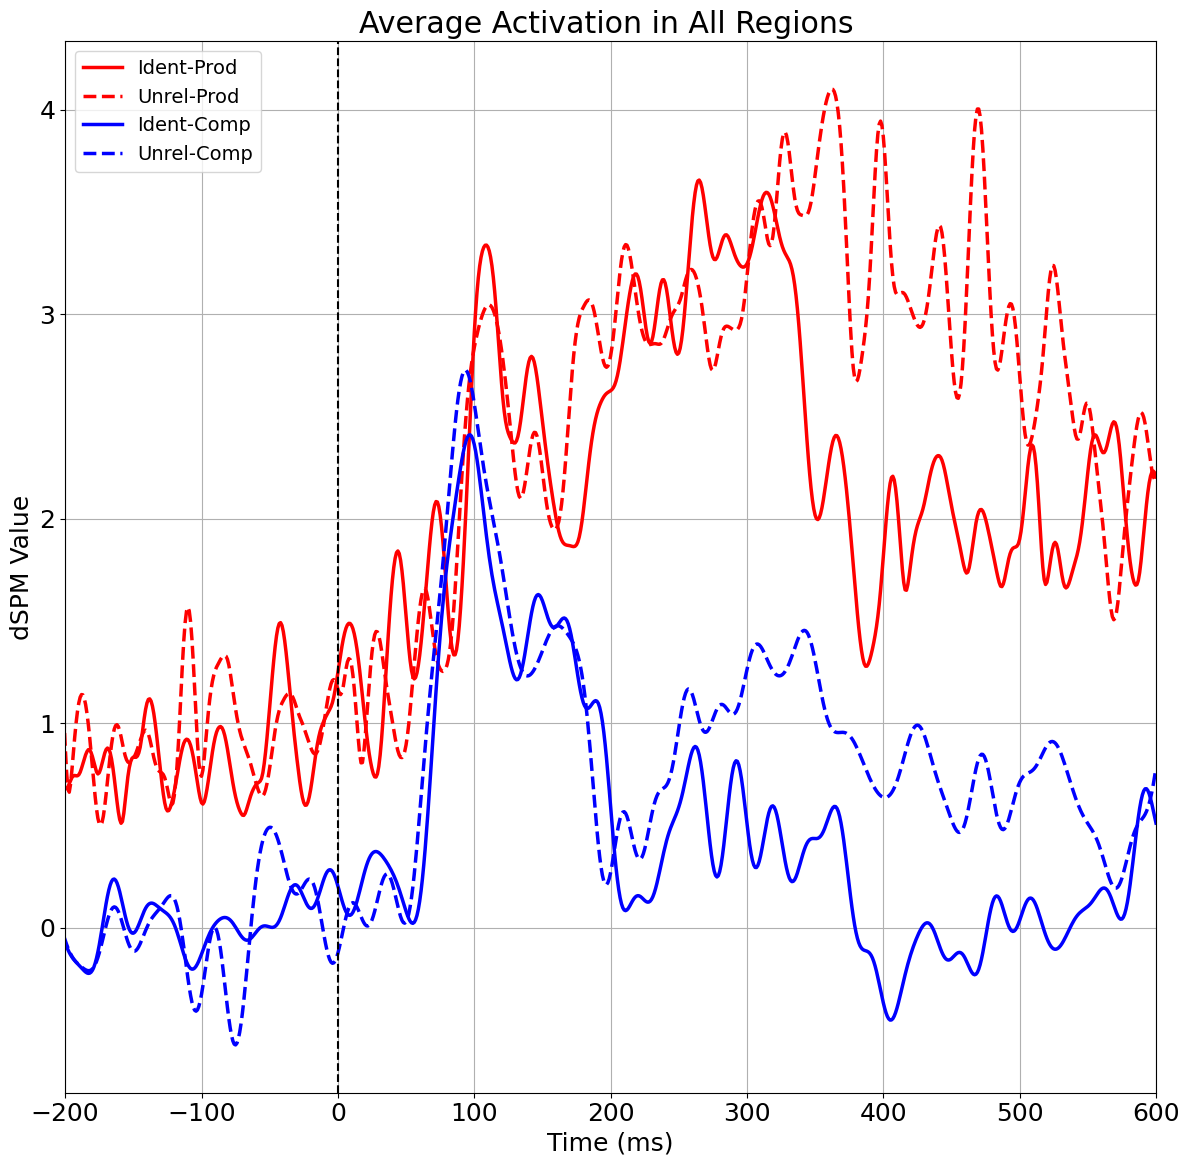

In [14]:
condition_stcs = {
    'Ident-Prod': avg_ident_prod,
    'Unrel-Prod': avg_unrel_prod,
    'Ident-Comp': avg_ident_comp,
    'Unrel-Comp': avg_unrel_comp
}

# condition_stcs = {
#     'Difference Prod': prod_dif,
#     'Difference Comp': comp_dif,
# }

plot_roi_ga(condition_stcs, 'Left', region="all")

Reading labels from parcellation...
   read 75 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/lh.aparc.a2009s.annot
Reading labels from parcellation...
   read 75 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/rh.aparc.a2009s.annot


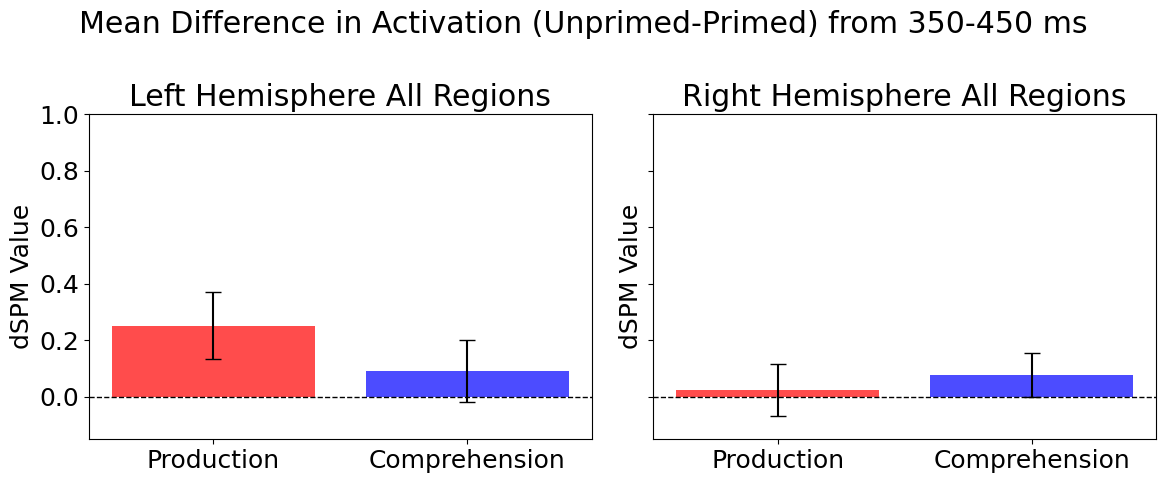

In [178]:
plot_roi_ga_bar_bihemi(
    ident_prod_stcs,
    unrel_prod_stcs,
    ident_comp_stcs,
    unrel_comp_stcs,
    region="all",
    tmin=350,
    tmax=450,
)

Reading labels from parcellation...
   read 75 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/lh.aparc.a2009s.annot
Reading labels from parcellation...
   read 75 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/rh.aparc.a2009s.annot


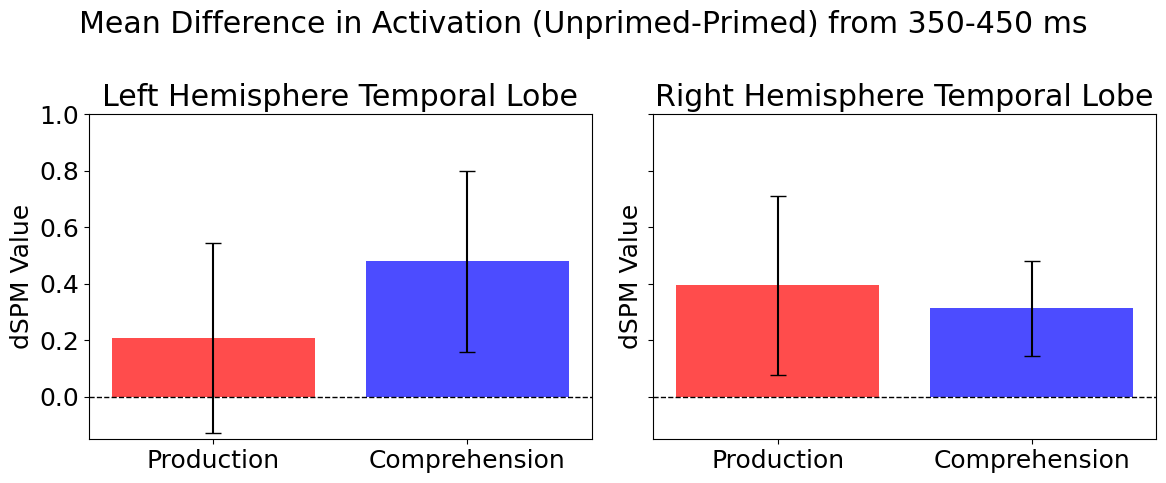

In [181]:
plot_roi_ga_bar_bihemi(
    ident_prod_stcs,
    unrel_prod_stcs,
    ident_comp_stcs,
    unrel_comp_stcs,
    region="temporal",
    tmin=350,
    tmax=450,
)

Reading labels from parcellation...
   read 75 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/lh.aparc.a2009s.annot
Reading labels from parcellation...
   read 75 labels from /Applications/freesurfer/8.0.0/subjects/fsaverage/label/rh.aparc.a2009s.annot


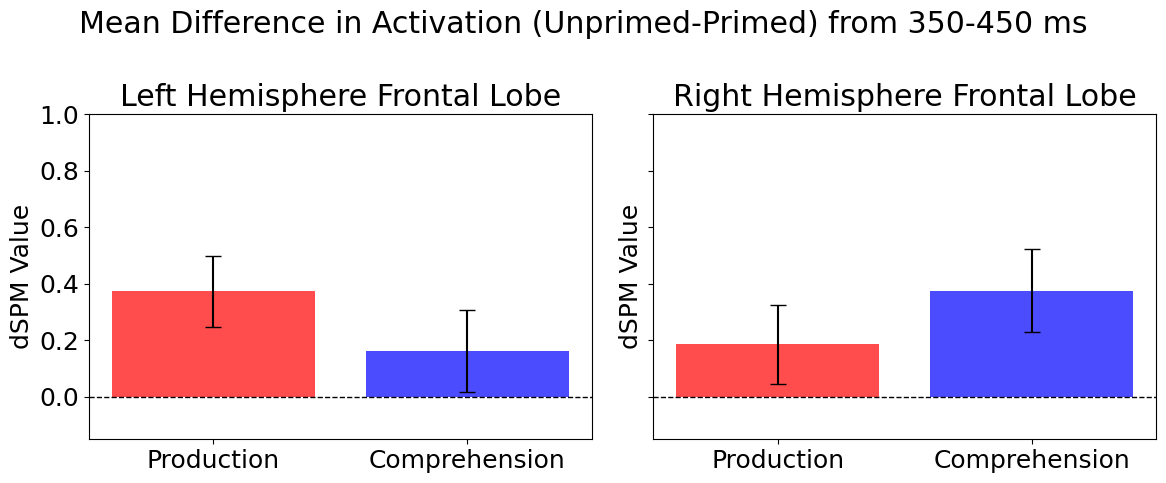

In [182]:
plot_roi_ga_bar_bihemi(
    ident_prod_stcs,
    unrel_prod_stcs,
    ident_comp_stcs,
    unrel_comp_stcs,
    region="frontal",
    tmin=350,
    tmax=450,
)

 # Audio Localization Loading and Plotting

In [ ]:
subs = ['R3250', 'R3254', 'R3261', 'R3264', 'R3270', 'R3271', 'R3272', 'R3273', 'R3275', 'R3277', 'R3279', 'R3285',
        'R3286', 'R3289', 'R3290']

n_subjects = len(subs)
subjects_dir = '/Applications/freesurfer/8.0.0/subjects'
src_fname = '/Applications/freesurfer/8.0.0/subjects/fsaverage/bem/fsaverage-ico-4-src.fif'

# arrays where the stcs for each condition will be stored
aud_prod_stcs = []
aud_comp_stcs = []

# Reading the source space for fsaverage
src = mne.read_source_spaces(src_fname)
fsave_vertices = [s["vertno"] for s in src]

for sub in subs:
    directory = '/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/' + sub + '/'
    stc_aud_comp_fsavg, stc_aud_prod_fsavg = get_stcs_aud(subjects_dir, directory, sub)
    tstep = stc_aud_prod_fsavg.tstep * 1000

    aud_prod_stcs.append(stc_aud_prod_fsavg)
    aud_comp_stcs.append(stc_aud_comp_fsavg)

    # Grand average for one condition (you can repeat this for others)
    avg_aud_prod = grand_average_stcs(ident_prod_stcs)
    avg_aud_comp = grand_average_stcs(unrel_prod_stcs)

In [ ]:
brain = avg_aud_prod.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    clim=dict(kind="value", lims=[0.5, 2, 3.5]),
    smoothing_steps=7,
    initial_time=0.4,
    title='Production -- Auditory'
        )
brain.add_text(0.4, 0.9, 'Production -- Auditory', "title", font_size=14)

In [ ]:
brain = avg_aud_comp.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    clim=dict(kind="value", lims=[0.5, 2, 3.5]),
    smoothing_steps=7,
    initial_time=0.4,
    title='Comprehension -- Auditory'
        )
brain.add_text(0.4, 0.9, 'Comprehension -- Auditory', "title", font_size=14)